In [1]:
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.runconfig import RunConfiguration, MpiConfiguration
from azureml.train.estimator import Estimator
from azureml.core.compute import ComputeTarget, AmlCompute

## Get workspace

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='benchy', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters_benchmarking')

## Setup dataset

In [3]:
if 'weather-files' not in ws.datasets:
    ds = Dataset.File.from_files('https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet', validate=False)
    ds = ds.register(ws, 'weather-files')
else:
    ds = ws.datasets['weather-files']
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "5a3248d1-e0ee-49b1-8e2b-d5167afa0e6c",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='benchy', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters_benchmarking')"
  }
}

## Setup parameters 

In [4]:
# {compute_name: (vCPUs, RAM, DISK, $/hr)}

MAX_VCPUS = 1000
MIN_RAM   = 100
MAX_RAM   = 1000

computes = {
    #'STANDARD_D12'    : (4,  28,  200,  .386),
    'STANDARD_D12_V2' : (4,  28,  200,  .370),
    #'STANDARD_D13'    : (8,  56,  400,  .771),
    'STANDARD_D13_V2' : (8,  56,  400,  .741),
    'STANDARD_DS12_V2': (4,  28,   56,  .370),
    'STANDARD_DS13_V2': (8,  56,  112,  .741),
    'STANDARD_DS15_V2': (20, 140, 280, 1.852),
    'STANDARD_DS5_V2' : (16,  56, 112, 1.170),
    #'STANDARD_F32S_V2': (32, 64,  256, 1.360)
}

In [5]:
vm_sizes = list(computes)
nodeses  = list(reversed([1, 2, 5, 10, 20]))

## Create clusters

In [6]:
for vm_size in vm_sizes:
    ct_name = vm_size.replace('STANDARD_', '').replace('_', '-')
    if ct_name not in ws.compute_targets:
        # create config for Azure ML cluster
        # change properties as needed
        # final default values for blog tbd - need to benchmark and minimize cost
        config = AmlCompute.provisioning_configuration(
                 vm_size                 = vm_size,
                 max_nodes               = max(nodeses),
                 vnet_resourcegroup_name = ws.resource_group,
                 vnet_name               = 'bench-vnet',
                 subnet_name             = 'default'
        )

        ct = ComputeTarget.create(ws, ct_name, config)
        ct.wait_for_completion(show_output=True)    
    else:
        print(f'{ct_name} already exists')

D12-V2 already exists
D13-V2 already exists
DS12-V2 already exists
DS13-V2 already exists
DS15-V2 already exists
DS5-V2 already exists


## Submit jobs

In [7]:
exp = Experiment(ws, 'describe')

for nodes in nodeses:
    print(f'\nNodes: {nodes}')
    for vm_size in vm_sizes:
        ct_name = vm_size.replace('STANDARD_', '').replace('_', '-')
        
        vcpus, ram, disk, wage = [x*nodes for x in computes[vm_size]]
        
        if vcpus < MAX_VCPUS and ram > MIN_RAM and ram < MAX_RAM:
            print(f'\t| VM Size - {vm_size:16} | vCPUs - {vcpus} | RAM - {ram}GB | WAGE - ${round(wage, 3)}/hr |')
            
            est = Estimator('code', 
                            compute_target=ws.compute_targets[ct_name], 
                            entry_script='runDask.py', 
                            conda_dependencies_file='environment.yml', 
                            #script_params={'--datastore': ws.get_default_datastore()},
                            inputs=[ds.as_named_input('weather').as_download('/tmp/noaa')],
                            node_count=nodes,
                            distributed_training=MpiConfiguration())
            
            print('\t\tSubmitting run...')
            run = exp.submit(est)
            run.log('nodes', nodes)
            run.log('vm_size', vm_size)
            run.log('vcpus', vcpus)
            run.log('ram', ram)
            run.log('disk', disk)
            run.log('wage', wage)
            print('\t\tRun submitted...')


Nodes: 20
	| VM Size - STANDARD_D12_V2  | vCPUs - 80 | RAM - 560GB | WAGE - $7.4/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_DS12_V2 | vCPUs - 80 | RAM - 560GB | WAGE - $7.4/hr |
		Submitting run...
		Run submitted...

Nodes: 10
	| VM Size - STANDARD_D12_V2  | vCPUs - 40 | RAM - 280GB | WAGE - $3.7/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_D13_V2  | vCPUs - 80 | RAM - 560GB | WAGE - $7.41/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_DS12_V2 | vCPUs - 40 | RAM - 280GB | WAGE - $3.7/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_DS13_V2 | vCPUs - 80 | RAM - 560GB | WAGE - $7.41/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_DS5_V2  | vCPUs - 160 | RAM - 560GB | WAGE - $11.7/hr |
		Submitting run...
		Run submitted...

Nodes: 5
	| VM Size - STANDARD_D12_V2  | vCPUs - 20 | RAM - 140GB | WAGE - $1.85/hr |
		Submitting run...
		Run submitted...
	| VM Size - STANDARD_D13_V2  | vCPUs - 40 

## Visualize data

In [6]:
exp = Experiment(ws, 'describe')
exp

Name,Workspace,Report Page,Docs Page
describe,benchy,Link to Azure Machine Learning studio,Link to Documentation


In [15]:
data    = []
    
for run in list(exp.get_runs()):
    runid   = run.id
    print(runid)
    metrics = run.get_metrics()
    nodes   = metrics['nodes']
    vm_size = metrics['vm_size']
    vcpus   = metrics['vcpus']
    wage    = metrics['wage']
    ram     = metrics['ram']
    disk    = metrics['disk']

    if run.get_status() == 'Completed' and 'duration' in metrics and 'cost' not in metrics:
        cost = metrics['duration']*wage/60/60
        print(f'Total cost: ${cost}')
        run.log('cost', f'${round(cost, 4)}')
    
    metrics = run.get_metrics()
        
    if run.get_status() == 'Completed' and 'cost' in metrics:
        cost = metrics['cost']
        duration = metrics['duration']
        data.append([runid, nodes, vm_size, vcpus, wage, ram, disk, cost, duration])

describe_1576980205_e36001e3
describe_1576979922_b2dd4f0a
describe_1576980259_b3689bd0
describe_1576980099_bd38c24f
describe_1576980368_4a5c951c
describe_1576980012_2fd2d782
describe_1576980233_12d16c65
describe_1576980152_554b09c7
describe_1576979985_287f17a1
describe_1576980313_1b85b1de
describe_1576980391_238f6d7a
describe_1576980340_2c65a67a
describe_1576980067_15046e2c
describe_1576979958_809cdeb8
describe_1576980285_d6f380a2
describe_1576980179_63ccf9b6
describe_1576980125_ca10b665
describe_1576980040_8a1a0f5b


In [16]:
data

[['describe_1576980205_e36001e3',
  5,
  'STANDARD_DS13_V2',
  40,
  3.705,
  280,
  560,
  '$0.2967',
  288.2893776893616],
 ['describe_1576980012_2fd2d782',
  10,
  'STANDARD_D13_V2',
  80,
  7.41,
  560,
  4000,
  '$0.215',
  104.43432354927063],
 ['describe_1576980233_12d16c65',
  5,
  'STANDARD_DS15_V2',
  100,
  9.26,
  700,
  1400,
  '$1.003',
  389.9453535079956],
 ['describe_1576979985_287f17a1',
  10,
  'STANDARD_D12_V2',
  40,
  3.7,
  280,
  2000,
  '$0.6338',
  616.6657111644745],
 ['describe_1576980313_1b85b1de',
  2,
  'STANDARD_DS13_V2',
  16,
  1.482,
  112,
  224,
  '$0.2207',
  536.1288964748383],
 ['describe_1576980391_238f6d7a',
  1,
  'STANDARD_DS15_V2',
  20,
  1.852,
  140,
  280,
  '$0.6874',
  1336.1754627227783],
 ['describe_1576980067_15046e2c',
  10,
  'STANDARD_DS13_V2',
  80,
  7.41,
  560,
  1120,
  '$0.2531',
  122.94134330749512],
 ['describe_1576980285_d6f380a2',
  2,
  'STANDARD_D13_V2',
  16,
  1.482,
  112,
  800,
  '$0.4342',
  1054.6599462032318]

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
headers = ['runid', 'nodes', 'vm_size', 'vcpus', 'wage', 'ram', 'disk', 'cost', 'duration']

df = pd.DataFrame(data, columns=headers)
df.cost = df.cost.str.replace('$', '')
df.cost = df.cost.astype(float)
df

,runid,nodes,vm_size,vcpus,wage,ram,disk,cost,duration
0,describe_1576980205_e36001e3,5,STANDARD_DS13_V2,40,3.705,280,560,0.2967,288.289378
1,describe_1576980012_2fd2d782,10,STANDARD_D13_V2,80,7.410,560,4000,0.2150,104.434324
2,describe_1576980233_12d16c65,5,STANDARD_DS15_V2,100,9.260,700,1400,1.0030,389.945354
3,describe_1576979985_287f17a1,10,STANDARD_D12_V2,40,3.700,280,2000,0.6338,616.665711
4,describe_1576980313_1b85b1de,2,STANDARD_DS13_V2,16,1.482,112,224,0.2207,536.128896
5,describe_1576980391_238f6d7a,1,STANDARD_DS15_V2,20,1.852,140,280,0.6874,1336.175463
6,describe_1576980067_15046e2c,10,STANDARD_DS13_V2,80,7.410,560,1120,0.2531,122.941343
7,describe_1576980285_d6f380a2,2,STANDARD_D13_V2,16,1.482,112,800,0.4342,1054.659946


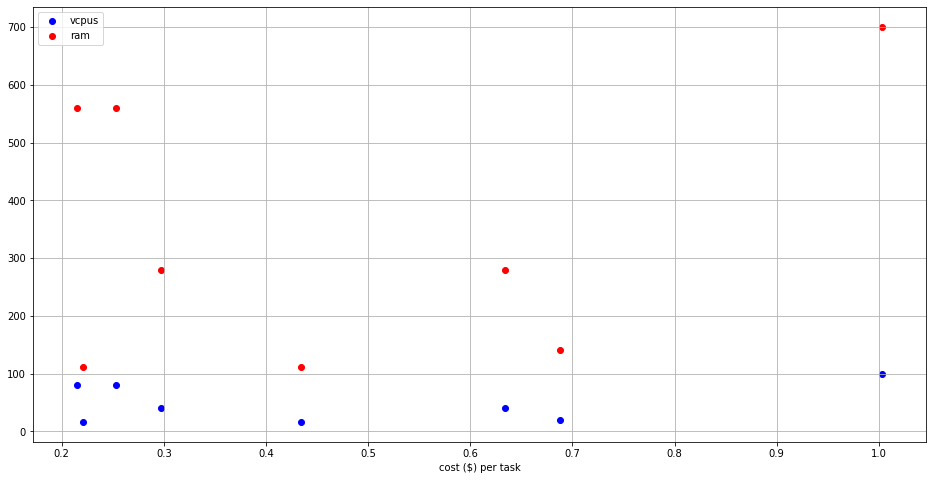

In [39]:
plt.figure(figsize=(16, 8))
plt.scatter(df.cost, df.vcpus, color='b', label='vcpus')#, labels=df.cost)
plt.scatter(df.cost, df.ram, color='r', label='ram')
plt.xlabel('cost ($) per task')
plt.legend()
plt.grid()

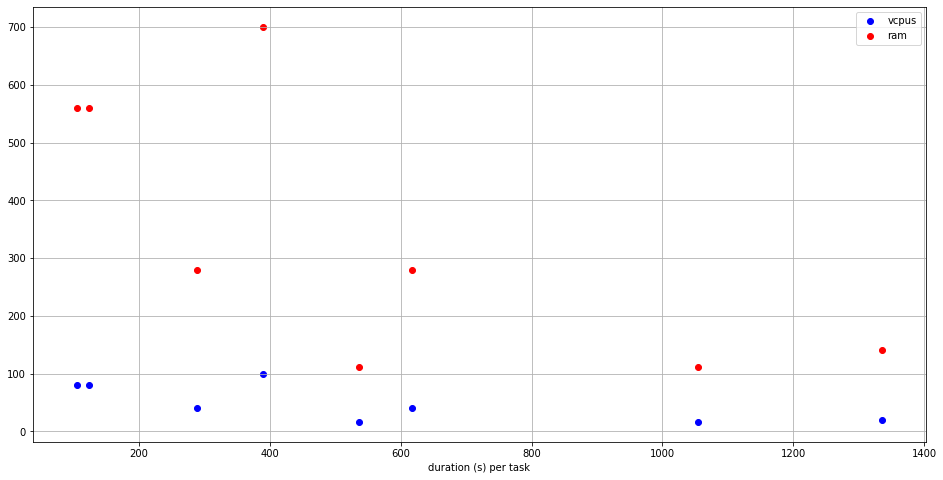

In [40]:
plt.figure(figsize=(16, 8))
plt.scatter(df.duration, df.vcpus, color='b', label='vcpus')#, labels=df.cost)
plt.scatter(df.duration, df.ram, color='r', label='ram')
plt.xlabel('duration (s) per task')
plt.legend()
plt.grid()

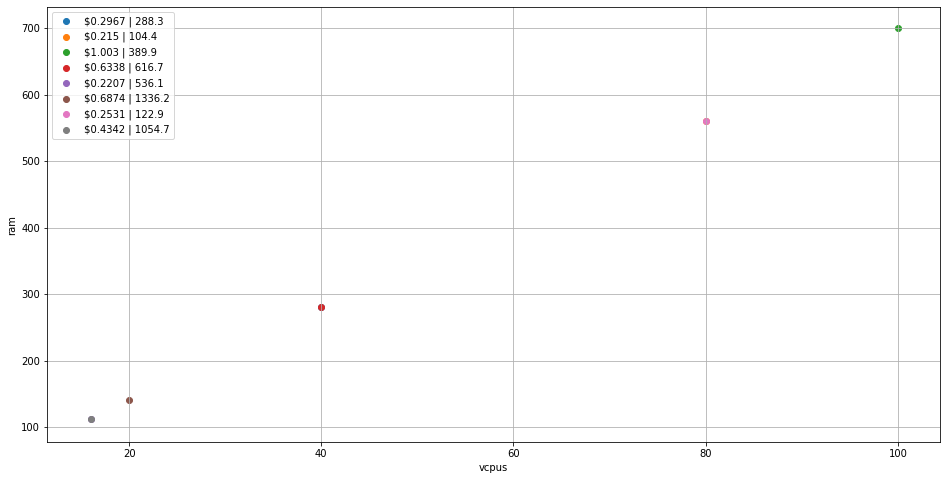

In [44]:
plt.figure(figsize=(16, 8))

for x in data:
    vcpus, ram, cost, duration = (x[3], x[5], x[7], x[8])
    plt.scatter(vcpus, ram, label=f'{cost} | {round(duration, 1)}')

plt.xlabel('vcpus')
plt.ylabel('ram')
plt.legend()
plt.grid()

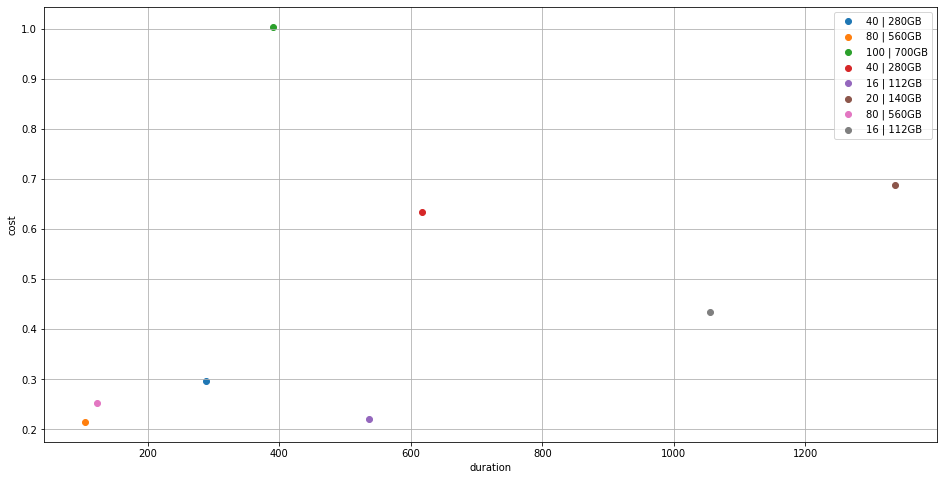

In [54]:
plt.figure(figsize=(16, 8))

for x in data:
    vcpus, ram, cost, duration = (x[3], x[5], float(x[7].replace('$', '')), x[8])
    plt.scatter(duration, cost, label=f'{vcpus} | {ram}GB')

plt.xlabel('duration')
plt.ylabel('cost')
plt.legend()
plt.grid()

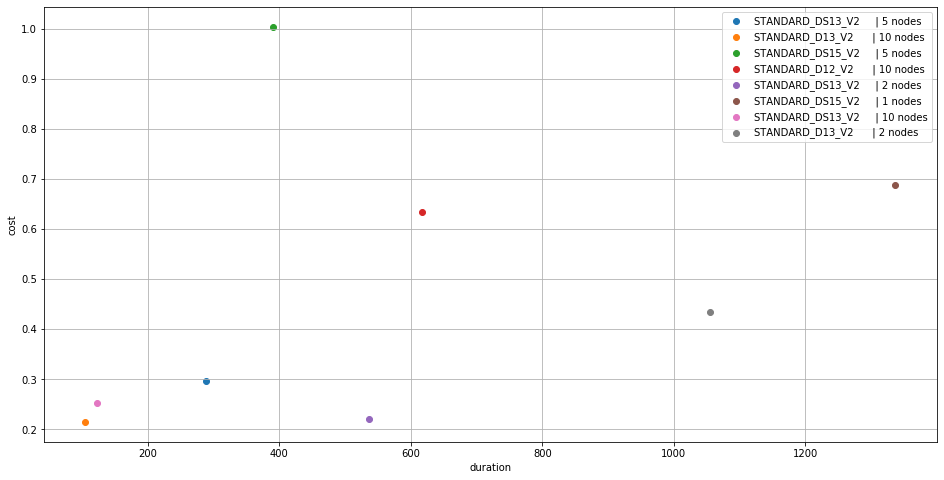

In [55]:
plt.figure(figsize=(16, 8))

for x in data:
    vm_size, nodes, cost, duration = (x[2], x[1], float(x[7].replace('$', '')), x[8])
    plt.scatter(duration, cost, label=f'{vm_size:20} | {nodes} nodes')

plt.xlabel('duration')
plt.ylabel('cost')
plt.legend()
plt.grid()

In [22]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA sequen

## Kill clusters

In [ ]:
for ct in ws.compute_targets:
    #ws.compute_targets[ct].delete()
    pass

ws.compute_targets

## Cancel runs

In [23]:
exp = Experiment(ws, 'describe')

for run in exp.get_runs():
    if run.get_status() == 'Running':
        print(f'Cancelling {run.id}...')
        run.cancel()